In [1]:
from tensorflow import keras

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Load the dataset
data = pd.read_csv('fer2013.csv')

# Assuming the dataset has a column 'pixels' containing image data and 'emotion' as labels
# Convert pixels into numpy arrays
data['pixels'] = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48, 1).astype('float32'))

# Split the dataset into features and labels
X = data['pixels'].tolist()
y = data['emotion'].values

class_names = [ #list of available emotions in the dataset
    "Angry",
    "Disgust",
    "Fear",
    "Happy",
    "Sad",
    "Surprize",
    "Neutral"
]
img_size=224
num_classes = 7
batch_size = 64

# Stratify split the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42)


In [3]:
def preprocess_image(image):
    image = tf.image.resize(image, [img_size, img_size])  # Resize to 48x48
    image /= 255.0  # Normalize pixel values
    image = tf.image.grayscale_to_rgb(image)  # Convert grayscale to RGB
    return image

def augment(image, label):
    # Data augmentation (random flip, rotation, etc.)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label


# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply preprocessing and augmentation
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y)).map(augment).shuffle(1000).batch(batch_size)
val_dataset = val_dataset.map(lambda x, y: (preprocess_image(x), y)).batch(32)
test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y)).batch(32)


2024-01-18 10:44:51.641855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 10:44:53.581828: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-18 10:44:53.581882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 55227 MB memory:  -> device: 0, name: A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0
2024-01-18 10:44:53.584427: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH 

In [4]:
#Models - cait_xxs24_224, cait_xxs24_384, cait_xxs36_224, cait_xxs36_384, cait_xs24_384, cait_s24_224, cait_s24_384, cait_s36_384, cait_m36_384, cait_m48_448

model_path = "gs://tfhub-modules/sayakpaul/cait_xxs24_224/1/uncompressed"
inputs = tf.keras.Input((img_size, img_size, 3))
hub_module = tf.keras.models.load_model(model_path)

x, _, _ = hub_module(inputs)  # Second and third outputs in the tuple is a
# dictionary containing attention scores.

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)




2024-01-18 10:47:26.202830: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


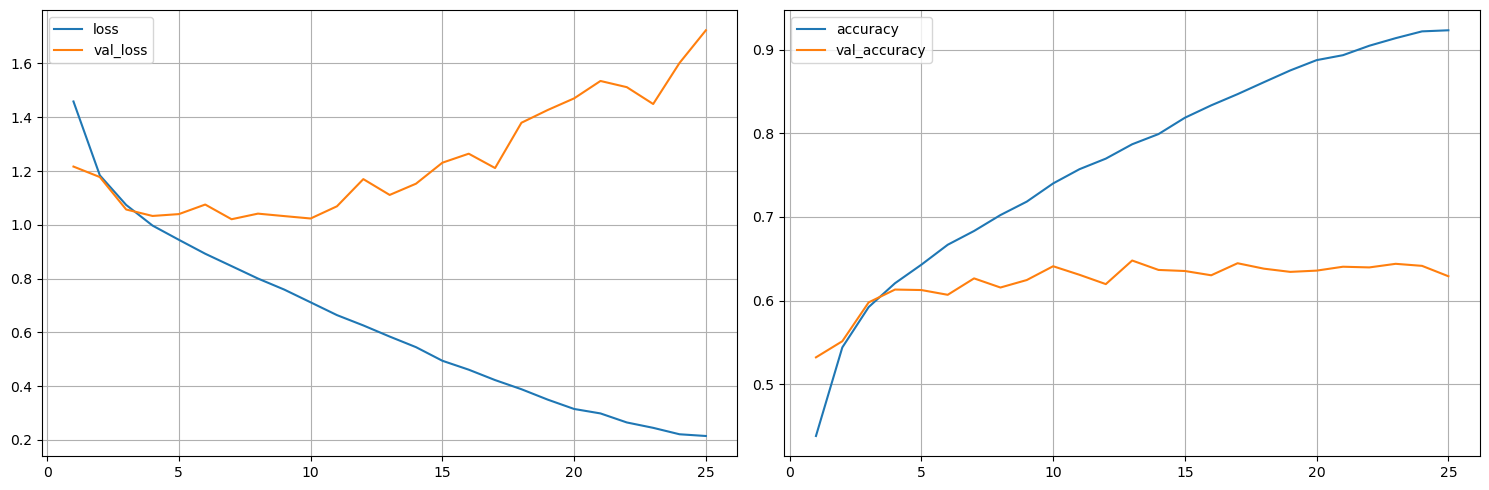

314/314 [==============================] - 210s 661ms/step - loss: 0.2148 - accuracy: 0.9231 - val_loss: 1.7234 - val_accuracy: 0.6290


In [5]:
from plot_callback import PlotLearning

initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=25,callbacks=[PlotLearning()]
)

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.46      0.53       991
           1       0.53      0.52      0.53       109
           2       0.47      0.43      0.45      1024
           3       0.89      0.83      0.86      1798
           4       0.52      0.55      0.53      1216
           5       0.63      0.87      0.73       800
           6       0.59      0.62      0.60      1240

    accuracy                           0.64      7178
   macro avg       0.61      0.61      0.60      7178
weighted avg       0.64      0.64      0.64      7178

Confusion Matrix:


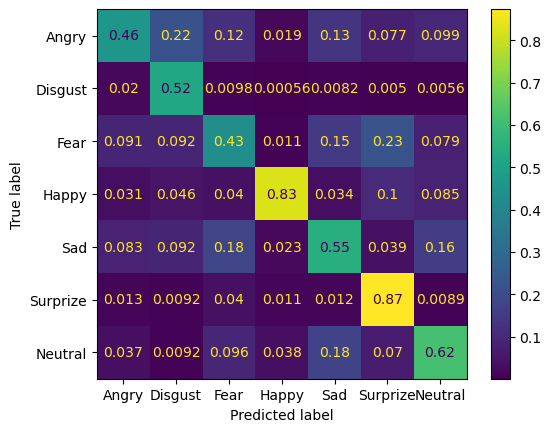

In [6]:
from sklearn.metrics import classification_report, confusion_matrix , ConfusionMatrixDisplay
import numpy as np

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Classification reportN
print("Classification Report:")
print(classification_report(y_test, y_pred_classes,labels=[0, 1, 2, 3, 4, 5, 6]))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
cm = cm / cm.astype(np.float64).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

disp.plot()
plt.show()

# Fixing Class Imbalance

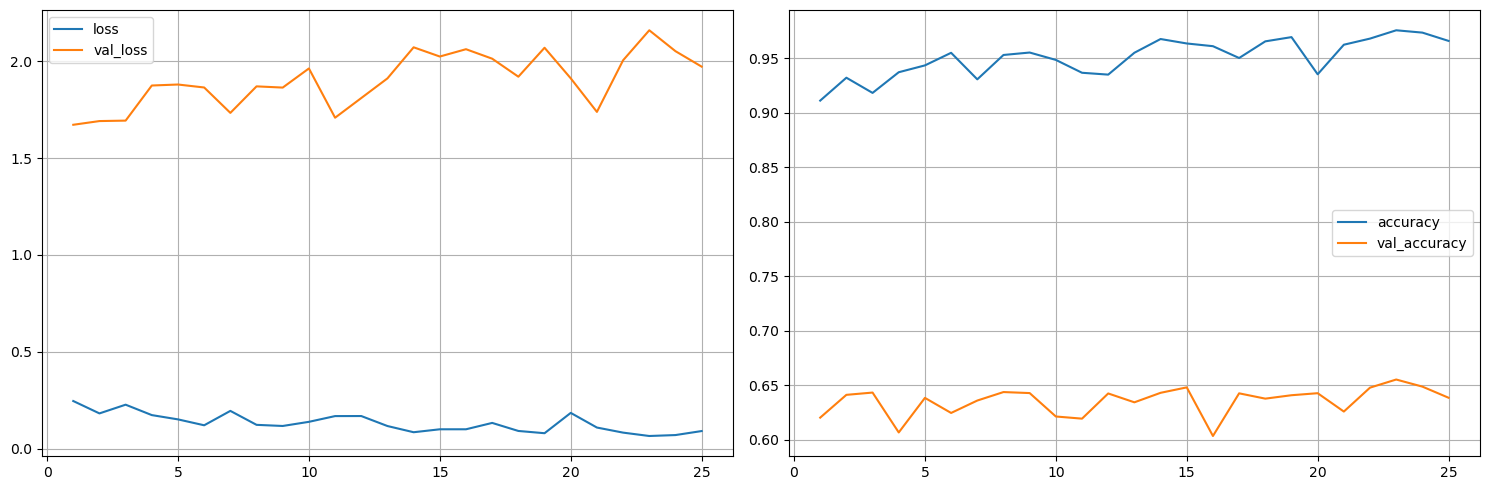

314/314 [==============================] - 171s 535ms/step - loss: 0.0916 - accuracy: 0.9658 - val_loss: 1.9717 - val_accuracy: 0.6386


In [7]:
from sklearn.utils.class_weight import compute_class_weight
from plot_callback import PlotLearning


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Use these class weights in model training
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=25, class_weight=class_weight_dict,callbacks=[PlotLearning()]) 

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       991
           1       0.50      0.52      0.51       109
           2       0.50      0.48      0.49      1024
           3       0.89      0.81      0.85      1798
           4       0.54      0.52      0.53      1216
           5       0.73      0.83      0.78       800
           6       0.57      0.63      0.60      1240

    accuracy                           0.65      7178
   macro avg       0.61      0.62      0.62      7178
weighted avg       0.65      0.65      0.65      7178

Confusion Matrix:


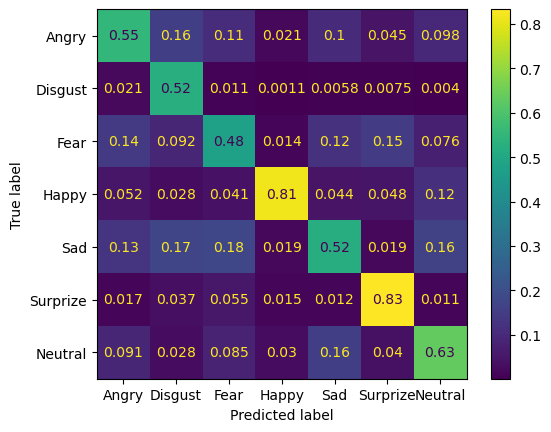

In [8]:
from sklearn.metrics import classification_report, confusion_matrix , ConfusionMatrixDisplay
import numpy as np

# Predict on the test dataset
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes,labels=[0, 1, 2, 3, 4, 5, 6]))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_classes)
cm = cm / cm.astype(np.float64).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)

disp.plot()
plt.show()